# SmallNORB

SmallNORB is a dataset used in machine learning. It shows toys from various angles and in different lighting.

It's available here: https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/

This notebook:
 - downloads the files
 - parses the files' headers and loads the data into numpy arrays
 - draws a few of the images and has an interactive tool.

I've only tested this on Python 3.5 on a Mac. Other than that, it should only require numpy, jupyter, and matplotlib.

You might also be interested in https://github.com/ndrplz/small_norb/ which also helped me figure out how to do this in Python.

## Overview of files

Before I start, here's an overview of the dataset based on information from [the page (the source of truth for this dataset!)](https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/)

There are a number of toys of different categories. Each toy is photographed from a fixed number of angles and lighting. The toys are grouped into one of 5 categories such as 'cars'. In each category, there are 10 toys which are referred to as an "instances." 

There are two sets of files, one for training and one for testing. The training and testing datasets are divided across instances. So the 24,300 examples of instances 4, 6, 7, 8, 9 of all classes make up the training set. 

Each set contains three files. Each file's first dimension represents the 24,300 examples. The files are:

 - **`dat`**: The images! An example is of size `(2, 96, 96)`. This represents two `(96, 96)` images, one for each of two cameras.
 - **`cat`**: An example is an int. This represents the category id.
 - **`info`**: An example is `(4,)`. This represents the metadata about lighting/angle/etc. Specifically:
   - **`instance`**: id `[0-9]` of which toy from the category it is.
   - **`elevation`**: id `[0-8]` representing the elevation of the camera (from 30 to 70 using increments of 5).
   - **`azimuth`**: id `[0-34]` (only even numbers!), where multiplying by 10 represents the azimuth. Heads up that instances aren't aligned! `azimuth=0` for two toys will point in two different directions.
   - **`lighting`**: id `[0-5]` representing the lighting.

In [1]:
from collections import namedtuple
import gzip
import os
import requests
import struct

import matplotlib.pyplot as plt
import numpy as np

## Downloading

The next code block downloads and decompresses the 6 files from https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/ in the `DATA_FOLDER` location.
If you already have the decompressed files, you can point `DATA_FOLDER` to their folder.

*Heads up, the `dat` files are large. This may take a while.*

In [2]:
DATA_FOLDER = 'data'
URL = 'https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/'

PREFIXES = {
    'train': 'smallnorb-5x46789x9x18x6x2x96x96-training-',
    'test': 'smallnorb-5x01235x9x18x6x2x96x96-testing-',
}

FILE_TYPES = ['info', 'cat', 'dat']

SUFFIX = '.mat'

for prefix in PREFIXES.values():
    for file_type in FILE_TYPES:
        file_name = prefix + file_type + SUFFIX
        output_location = os.path.join(DATA_FOLDER, file_name)
        file_location = URL + file_name + '.gz'
        
        if os.path.exists(output_location):
            print('skipping {}, already downloaded'.format(output_location))
            continue
        
        print('Downloading {} to {}'.format(file_location, output_location))

        r = requests.get(file_location)
        with open(output_location, 'wb') as f:
            f.write(gzip.decompress(r.content))

skipping data/smallnorb-5x46789x9x18x6x2x96x96-training-info.mat, already downloaded
skipping data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat, already downloaded
skipping data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat, already downloaded
skipping data/smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat, already downloaded
skipping data/smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat, already downloaded
skipping data/smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat, already downloaded


## Reading the files

[The site](https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/) walks through how the files are represented.
Each of the files has a header that explains how to read the data structure of the rest of the file. 

In this block, for each file, I read the header, then use it to load a numpy array of the file.

In [3]:
# helper function to read int from file
def read_int(f):
    num, = struct.unpack('i', f.read(4))
    return num


# From https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/ 
# "The magic number encodes the element type of the matrix"
# Note: I only copied over the ones I needed for these files.
map_magic_number_to_data_type = {
    '1e3d4c55': np.uint8,
    '1e3d4c54': np.int32,
}

loaded_data = {}

for dataset, prefix in PREFIXES.items():
    for filetype in FILE_TYPES:
        filename = prefix + filetype + SUFFIX
        print('Reading {}'.format(filename))
        
        file_loc = os.path.join(DATA_FOLDER, filename)
        with open(file_loc, 'rb') as f:
            # Read the magic_num, convert it to hexadecimal, and look up the data_type
            raw_magic_num = read_int(f)
            magic_num = format(raw_magic_num, '02x')
            data_type = map_magic_number_to_data_type[magic_num]
            print('dtype', data_type)

            # Read how many dimensions to expect
            ndim = read_int(f)
            
            # Read at least 3 ints, or however many ndim there are
            shape = [
                read_int(f)
                for i in range(max(ndim, 3))
            ]   
            # But in case ndims < 3, take at most n_dim elements
            shape = shape[:ndim]
            print('shape', shape)
    
            # Now load the actual data!
            loaded_data[(dataset, filetype)] = np.fromfile(
                f, 
                dtype=data_type, 
                count=np.prod(shape)
            ).reshape(shape)

Reading smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]


### Viewing an image

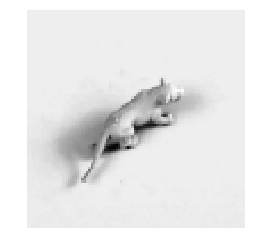

In [4]:
plt.imshow(loaded_data[('train', 'dat')][0, 0], cmap='gray')
plt.axis('off')
plt.show()

### Saving the data in a new format

If at this point, you want SmallNORB in `npz` file for another project, you could do something like:

    np.savez_compressed(
        'data/smallnorb-20180503-train.npz', 
        inputs=loaded_data[('train', 'dat'), 
        targets=loaded_data[('train', 'cat')],
    )

## Exploring the dataset

Now I'll explore the dataset.

The downloaded dataset splits instances across the train and test set. For exploration, I'm going to concatenate them and make a mapping from metadata and category to the image index.

In [5]:
# I'll index examples out of this dataset
all_dat = np.vstack((
    loaded_data[('train', 'dat')], 
    loaded_data[('test', 'dat')]
))


# These I'll use to build the example_lookup table
all_info = np.vstack((
    loaded_data[('train', 'info')], 
    loaded_data[('test', 'info')]
))
# hstack these because it's a 1d vec
all_targets = np.hstack((
    loaded_data[('train', 'cat')], 
    loaded_data[('test', 'cat')]
))

# I'll concatenate the category and the info. The info field names
# come from https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/
ExampleLookupKey = namedtuple('ExampleLookupKey', [
    'category',
    'instance',
    'elevation',
    'azimuth',
    'lighting',
])

# Map infos/category to the index of the image in `all_dat`
example_lookup = {
    ExampleLookupKey(category, *info): i
    for i, (info, category) in enumerate(zip(all_info, all_targets))
}

## Rotating image example

I can use the `example_lookup` dictionary to look-up related images. So for example, I can vary nothing but the azimuth.

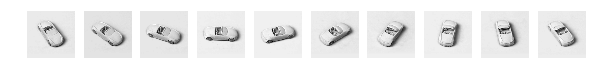

In [6]:
fig, axs = plt.subplots(1, 10, figsize=(10, 1))

for ax, azimuth_i in zip(axs, range(10)):
    # set everything else arbitrarily
    example_key = ExampleLookupKey(
        category=4,
        instance=8,
        elevation=2,
        azimuth=2 * azimuth_i,
        lighting=2, 
    )
    
    example_id = example_lookup[example_key]
    # limit to one of the cameras
    image = all_dat[example_id][0]
    
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

### Interactive exploration

This one is my favorite, though you'll need this notebook local to view it. I can use the sliders to rotate the toys or view different toys.

In [7]:
from ipywidgets import interact

# Hardcode more info from https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/
category_idx_to_label = [
    'animal',
    'human',
    'airplane',
    'truck',
    'car',
]

elevations_idx_to_label = list(range(30, 72, 5))

# Heads up, `info` contains only even values for azimuths
# So if I'm not using data from `info`, I need to index into this
# by first multiplying by 2
azimuth_id_to_label = list(range(0, 360, 10))

def draw_image(category, instance, elevation, azimuth, lighting, camera_b):
    camera = 1 if camera_b else 0

    example_key = ExampleLookupKey(
        category=category,
        instance=instance,
        elevation=elevation,
        azimuth=2 * azimuth, # azimuth in info is 2 * the index
        lighting=lighting, 
    )
    
    example_id = example_lookup[example_key]
    
    plt.imshow(all_dat[example_id, camera], cmap='gray')
    plt.axis('off')
    plt.show()

    print('category:', category_idx_to_label[category])
    print('example:', all_info[example_id][0])
    print('elevation:', elevations_idx_to_label[all_info[example_id][1]])
    print('azimuth:', azimuth_id_to_label[all_info[example_id][2]])
    print('lighting:', all_info[example_id][3])

interact(
    draw_image,
    category=(0, 4),    
    instance=(0, 9),
    elevation=(0, 8),
    azimuth=(0, 17),
    lighting=(0, 5),
    camera_b=False,    
)


interactive(children=(IntSlider(value=2, description='category', max=4), IntSlider(value=4, description='instance', max=9), IntSlider(value=4, description='elevation', max=8), IntSlider(value=8, description='azimuth', max=17), IntSlider(value=2, description='lighting', max=5), Checkbox(value=False, description='camera_b'), Output()), _dom_classes=('widget-interact',))

<function __main__.draw_image>